#This is the notebook of our Computer Vision project

-Lefebvre Alexandre, Marguet Emeric, Cherel Vincent, Gossec Yaël

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

#Download WildFire dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.45G/1.45G [01:07<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1


##Split the Dataset

We split the validation set into a new training and validation set

In [ ]:
import os
import shutil
import random

def split_images(source_folder, dest_folder1, dest_folder2):
    # Ensure destination folders exist
    os.makedirs(dest_folder1, exist_ok=True)
    os.makedirs(dest_folder2, exist_ok=True)

    # Get all image files in the source folder
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp', 'tiff'))]

    # Shuffle and split the images
    random.shuffle(images)
    split_index = len(images) // 2
    images1, images2 = images[:split_index], images[split_index:]

    # Copy images to the respective folders
    for img in images1:
        shutil.copy(os.path.join(source_folder, img), os.path.join(dest_folder1, img))

    for img in images2:
        shutil.copy(os.path.join(source_folder, img), os.path.join(dest_folder2, img))

    print(f"Copied {len(images1)} images to {dest_folder1}")
    print(f"Copied {len(images2)} images to {dest_folder2}")



In [ ]:
# split nowildfire part
source_folder = path+"/valid/nowildfire"
dest_folder1 = "trainDataset/nowildfire"
dest_folder2 = "validDataset/nowildfire"
split_images(source_folder, dest_folder1, dest_folder2)

Copied 1410 images to trainDataset/nowildfire
Copied 1410 images to validDataset/nowildfire


In [ ]:
#split wildfire part
source_folder = path+"/valid/wildfire"
dest_folder1 = "trainDataset/wildfire"
dest_folder2 = "validDataset/wildfire"
split_images(source_folder, dest_folder1, dest_folder2)

Copied 1740 images to trainDataset/wildfire
Copied 1740 images to validDataset/wildfire


#Model

In [ ]:
#Small cell to lauch to set training carac
n_ep=10 # number of epoch
weight_outputpath=f"/resnet50_wildfire_epo{n_ep}.pth"
loadFromPath = False

In [ ]:
#Small cell to lauch if you downloaded and want to use our weights
loadFromPath = True
weight_path="/resnet50_wildfire_epo10.pth" #if you drag and drop the weights in the collab that's the path that you should get

In [ ]:
#If you want to use your own validation/training data set change these variables
train_path="trainDataset"
valid_path="validDataset"

##Training

In [ ]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load pre-trained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)

# Modify the output layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
if loadFromPath:
    model.load_state_dict(torch.load(weight_path, map_location=device))

else:
    num_epochs = n_ep
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


    torch.save(model.state_dict(), weight_outputpath)
    print(f"Training completed! weight save at {weight_outputpath}")


Epoch [1/10], Loss: 0.2464
Epoch [2/10], Loss: 0.1518
Epoch [3/10], Loss: 0.1659
Epoch [4/10], Loss: 0.1582
Epoch [5/10], Loss: 0.1276
Epoch [6/10], Loss: 0.1114
Epoch [7/10], Loss: 0.1109
Epoch [8/10], Loss: 0.1063
Epoch [9/10], Loss: 0.0820
Epoch [10/10], Loss: 0.0581
Training completed! weight save at /resnet50_wildfire_epo10.pth


##Evaluation

In [ ]:
valid_dataset = ImageFolder(root=valid_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

class_names = valid_dataset.classes

model.eval()

incorrect_predictions=[]
correct = 0
total = 0

with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).squeeze()
        predictions = (outputs > 0).long()  # Convert logits to 0 or 1

        #small section to save incorect prediction if we want to visualize them
        image_paths = [valid_dataset.samples[i][0] for i in range(total, total + len(images))]
        for i in range(len(predictions)):
            if predictions[i] != labels[i]:
                incorrect_predictions.append((image_paths[i], class_names[labels[i].item()], class_names[predictions[i].item()]))


        # Compute accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 94.86%


Display some incorrect prediction

Image: validDataset/wildfire/-72.03686,45.84233.jpg
Expected: wildfire, Predicted: nowildfire


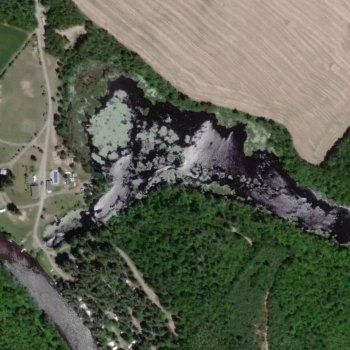

--------------------
Image: validDataset/wildfire/-79.03739,48.28058.jpg
Expected: wildfire, Predicted: nowildfire


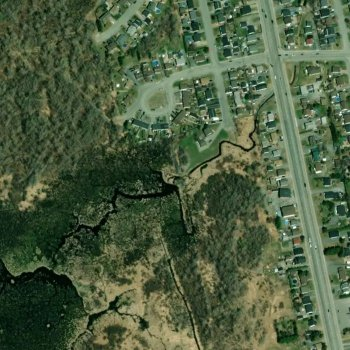

--------------------
Image: validDataset/wildfire/-74.15001,45.41607.jpg
Expected: wildfire, Predicted: nowildfire


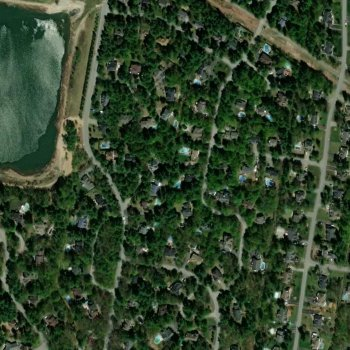

--------------------
Image: validDataset/wildfire/-72.0822,46.8303.jpg
Expected: wildfire, Predicted: nowildfire


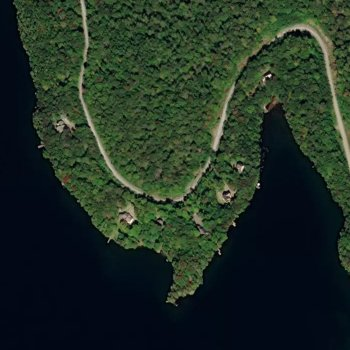

--------------------
Image: validDataset/wildfire/-79.01514,48.74671.jpg
Expected: wildfire, Predicted: nowildfire


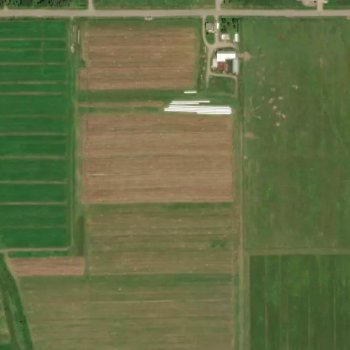

--------------------


In [ ]:
from IPython.display import Image, display
num_to_display = 5  # nombre de prediction erronée que l'on veut afficher
random_incorrect = random.sample(incorrect_predictions, min(num_to_display, len(incorrect_predictions)))

for image_path, expected_class, predicted_class in random_incorrect:
    print(f"Image: {image_path}")
    print(f"Expected: {expected_class}, Predicted: {predicted_class}")
    display(Image(filename=image_path))
    print("-" * 20)